# Genetic optimisation to reduce rate of infection in crowded spaces
 Plymouth University Comp Sci Bacherlor Showcase


In [62]:
from platypus import NSGAII, NSGAIII, Problem, Integer, Real, nondominated
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import cellpylib as cpl
import random

import cellpylibhack.functions2d as cplhack

plt.rcParams["animation.html"] = "jshtml"


## Contents
* [Problem](#problem)
* [Objectives](#objectives)
* [Evaluation](#evaluation)
* [Testing](#testing)

## Problem
Genetic code to optimise allows GA to control a number of environmental factors (windows, air conditioning) and social factors (face masks, social distance, vaccinated).

* Windows open / closed: influence air flow.
* Air conditioning: influence air flow in entire room.
* Face masks: agents wear face masks.
* Social distance: distance agents should keep between each other.
* Vaccinated: % of agents who are vaccinated.

Each factor can be toggled on / off or be hard set to challenge optimiser.

## Objectives
In order to explore compromising options (avoid simply maximise use of all measures), certain objectives need to be optimised in conflict with each other.

_Minimising_
* Infection count: minimise number of infected agents.
* Inverse social distance punishment: encourage minimal required social distancing.
* Inverse tempurature punishment: use of windows and air conditioning reduces room tempurature. Encourage minimal required use to prevent solution with uninhabitable room tempurature.
* Inverse vaccination punishment: find minimal required % of vaccinated agents to achieve positive impacts.

Inverse punishments encourage the GA to locate a balance between social measures and impact on score (simulating social pushback), if a balance is possible.

## Evaluation
* Use solution code to construct environment for CA.
* Simulate a random population for N epochs.
* Construct objective scores from simulation results.

In [63]:
class AutomataOptimisation(Problem):
    def __init__(
        self,
        environment,
        pathogen_info,
        n_objectives=3,
        init_infected_ratio=0.1,
        agentPopSize=10,
        epochs=50,
        verbose=0,
    ):
        """Optimise social and physical factors to minimise infection rate in enclosed environment.

        NOTE: '#' commented decision variables / objectices are not implemented at present. When implementing, adjust all indexing for accesses of solutions.

        Decision variables (indexed):
            [0-9]: window toggles for environment (boolean).
            #[10]: air conditioning toggle (boolean).
            #[11]: face mask toggle (boolean).
            [12]: social distancing (agents are disuaded from moving into spaces that violate social distancing, and will move away fron others if made to violate) (integer range 0-5 metres).
            #[13]: % of vaccinated agents (float).

        Objectives:
            [0]: Infection count (integer).
            [1]: Inverse social distance (integer).
            [2]: Inverse tempurature (float).
            #[3]: Inverse vaccination (float).

        """

        self.environment = environment

        # map solution features to map coordinates (for physical feature toggles)
        self.windowMap = np.empty((0, 2), dtype=int)
        for (x, y), value in np.ndenumerate(self.environment):
            if value == 2:  # if window, add coords to window list
                self.windowMap = np.append(self.windowMap, [[x, y]], axis=0)

        # decision variables = number of windows (physical) + social distance (social)
        decision_variables = self.windowMap.size + 1
        objectives = n_objectives

        super(AutomataOptimisation, self).__init__(decision_variables, objectives)

        # self.types[:] = [Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 1), Integer(0, 5), Real(0.0, 1.0)]
        self.types[:] = [
            [Integer(0, 1),] * self.windowMap.size,  # windows
            Integer(0, 5),  # social distance
        ]

        self.dimensions = self.environment.shape

        self.verbose = verbose

        self.agentPopSize = agentPopSize  # number of agents in simulation

        self.init_infected_ratio = init_infected_ratio

        self.epochs = (
            epochs  # number of simulation epochs for testing effectiveness of solution
        )
        self.max_airflow_epochs = 1000  # maximum epochs to allow airflow to run for before compromising with current best approximation

        # exemplar pathogen with strong contact infection and weak airborne infection, but slower airborne decay
        self.pathogen_info = pathogen_info

    def evaluate(self, solution):
        """Evaluate solution for fitness."""

        x = solution.variables[:]

        matrix, airflow = self.get_environment(x)
        agents = self.get_agents(matrix)

        solution.objectives[:] = self.simulate_environment(x, matrix, agents, airflow)

    def get_environment(self, solution):
        """Modify environment matrix by options.

        Inputs:
            solution: uses physical factors influencing environment.

        Outputs:
            matrix: map of environment, adjusted for physical factors.
            airflow: superimposed map of airflow in room.

        """

        matrix = self.environment[:]  # copy environment map

        # toggle for windows
        for idx, toggle in enumerate(solution[: self.windowMap.size]):  # indexes 0-9
            x, y = self.windowMap[idx]

            if toggle == 1:
                matrix[x][y] = 1  # set window to wall if not open

        # recalculate airflow map
        airflow = self.get_airflow(matrix)

        return matrix, airflow

    def get_airflow(self, matrix):
        """Calculate airflow map for environment by appling CA ruleset.

        Inputs:
            matrix: map of environment, with windows toggled open/closed.
            #toggle_ac: indicator of wether air conditioning is enabled in room or not.

        Outputs:
            airflow: map of airflow cell objects, indicating airflow velocity at given cell.

        """

        cellular_automaton = cpl.init_simple2d(*self.dimensions)

        # set positive and negative air sources
        for x, y in self.windowMap:
            if matrix[x][y] == 2:
                if y < 5:  # positive incoming pressure for windows in top half
                    pressure = 10000
                else:  # negative incoming pressure for windows in bottom half
                    pressure = -10000

                cellular_automaton[:, x, y] = pressure

        # hard set for testing
        # cellular_automaton[:, [0, 0, 0, 4, 5], [1, 5, 8, 9, 0]] = 10000
        # cellular_automaton[:, [8, 8, 9, 9, 9], [0, 9, 2, 5, 7]] = -10000

        airflow_ca = cpl.evolve2d(
            cellular_automaton,
            timesteps=self.until_fixed_point_or_max(),
            apply_rule=AirflowRule(matrix),
            neighbourhood="Moore",
        )

        if self.verbose > 0:
            airflow_ani = cpl.plot2d_animate(airflow_ca, show_grid=True, title="Airflow", interval=50, colormap='Blues')
            display(HTML(airflow_ani.to_jshtml()))

        airflow = airflow_ca[-1]  # final state == fixed state and correct airflow

        print("Number of timesteps to reach fixed point: %s" % len(airflow_ca))

        return airflow

    def until_fixed_point_or_max(self):
        """Run evolution till stable or reached max epochs.

        Outputs:
            _timesteps: callable function to determine if evolution has halted. Exits if previous and current generations are same state, or a maximum number of generations has been reached.

        """

        def _timesteps(ca, t):
            if len(ca) > 1:
                return (
                    False
                    if (ca[-2] == ca[-1]).all() or len(ca) >= self.max_airflow_epochs
                    else True
                )

            return True

        return _timesteps

    def get_agents(self, matrix):
        """Create population of agents.

        Inputs:
            solution: uses social factors influencing environment.

        Outputs:
            agents: population.

        """

        cellular_automaton = cpl.init_simple2d(*self.dimensions)

        # get list of valid non-wall cells to spawn agents in
        spawnpoints = np.empty((0, 2), dtype=int)
        for (x, y), value in np.ndenumerate(matrix):
            if value == 0:  # if air, then free for spawning
                spawnpoints = np.append(spawnpoints, [[x, y]], axis=0)

        # random shuffle coords and extract popSize list of spawnpoints
        random.shuffle(spawnpoints)

        init_infected = int(self.agentPopSize * self.init_infected_ratio)
        init_healthy = self.agentPopSize - init_infected

        for x, y in [coord for coord in spawnpoints[:init_infected]]:
            cellular_automaton[:, x, y] = 2

        for x, y in [coord for coord in spawnpoints[init_infected+1:init_healthy+1]]:
            cellular_automaton[:, x, y] = 1

        return cellular_automaton

    def simulate_environment(self, solution, matrix, agents, airflow):
        """Simulate environment for N epochs.

        Outputs:
            infection count: final number of infected agents.
            inverse social distance: social distance parameter fed from solution.
            inverse tempurature: number of windows open.

        """

        infection_count, inverse_social_distance, inverse_tempurature, = (
            int(),
            int(),
            float(),
        )

        inverse_tempurature = (
            self.windowMap.size
        )  # tempurature punishment == number of open windows
        inverse_social_distance = social_distance = solution[
            10
        ]  # social distance punishment == social distance policy, to discourage large distancing

        infection = cpl.init_simple2d(
            *self.dimensions
        )  # initialise empty space for airborne infection layer

        agent_ca, infection_ca = evolveParallel(
            agents,
            infection,
            timesteps=self.epochs,
            apply_rule1=AgentRule(matrix, social_distance, self.pathogen_info),
            apply_rule2=InfectionRule(matrix, airflow, pathogen_info),
            neighbourhood="Moore",
        )

        if self.verbose > 0:
            agent_ani = cpl.plot2d_animate(agent_ca, show_grid=True, title="Agents", interval=100, colormap='Accent')
            infection_ani = cpl.plot2d_animate(infection_ca, show_grid=True, title="Infection airflow", interval=100, colormap='YlGn')

            # render as js animations
            display(HTML(agent_ani.to_jshtml()))
            display(HTML(infection_ani.to_jshtml()))

        final_state = agent_ca[-1]

        infection_count = 0
        for (x, y), value in np.ndenumerate(final_state):
            if value == 2:  # state 2 == infected
                infection_count += 1

        return infection_count, inverse_social_distance, inverse_tempurature


In [64]:
class PathogenInfo:
    def __init__(
        self,
        infection_from_contact,
        infection_from_max_pollutants,
        max_pollutants,
        airborne_decay,
        pathogen_release_payload,
    ):
        """
        Attributes:
            infection from contact: chance of infection from contact with infected agent.
            infection from max pollutants: chance of infection from being exposed to maximum airborne pollutant concentration.
            max pollutants: airborne pollutants required to have full chance of infection_from_max_pollutants.
            airborne decay: rate of decay of pollutants from air.
            pathogen release payload: number of pollutants released by agent per epoch.

        """

        self.infection_from_contact = infection_from_contact
        self.infection_from_max_pollutants = infection_from_max_pollutants
        self.max_pollutants = max_pollutants
        self.airborne_decay = airborne_decay
        self.pathogen_release_payload = pathogen_release_payload


In [65]:
class AirflowRule(cpl.BaseRule):
    """Simulate positive airflow from windows, updating velocities of air in cells.

    Assumptions:
        * Windows are either negative or positive sources of pressure

    """

    def __init__(self, matrix):
        """
        Attributes:
            matrix: map environment indicating walls, to prevent air flow from passing impassable boundaries.
        """

        self.matrix = matrix

    def __call__(self, neighbourhood, coords, timestamp):
        """

        Inputs:
            neighbourhood: the neighbourhood.

            coords: the index of the current cell.

            timestamp: the current timestep.

        Outputs:
            airflow_value: the new cell state.

        """

        x, y = coords

        if not self.matrix[x][y] == 0:  # is window or is wall
            return neighbourhood[1][
                1
            ]  # return centre neighbour value == this cell value

        # remove neighbours if illegal (wraparound) or are walls
        valid_neighbour_values = np.array([])
        for (i, j), neighbour in np.ndenumerate(neighbourhood):
            if not (
                (x == 0 and i == 0)
                or (x == 9 and i == 2)
                or (y == 0 and j == 0)
                or (y == 9 and j == 2)
            ):
                valid_neighbour_values = np.append(valid_neighbour_values, neighbour)

        # evaluate neighbourhood to calculate pressure level at current position
        airflow_value = sum(
            [val / len(valid_neighbour_values) for val in valid_neighbour_values]
        )  # mean of filtered list, removing None (rejected) neighbours

        # update cell to be mean of neighbourhood
        return airflow_value


In [66]:
class AgentRule(cpl.BaseRule):
    """Simulate positive airflow from windows, updating velocities of air in cells.

    Assumptions:
        * Windows are either negative or positive sources of pressure

    """

    def __init__(self, matrix, social_distance, pathogen_info):
        """
        Attributes:
            matrix: map environment indicating walls, to prevent air flow from passing impassable boundaries.
            infection: map indicating airborne pathogens from air layer.
            social distance: target distance to encourage agents to stay away from each other.
            pathogen: infection object describing e.g.: chance of infection from contact.
        """

        self.matrix = matrix
        self.social_distance = social_distance
        self.pathogen_info = pathogen_info

    def __call__(
        self,
        neighbourhood,
        infection_neighbourhood,
        coords,
        timestamp,
        preview,
        infection_layer,
    ):
        """If called for an agent cell, update.

        Agent behaviour:
            1. Check surrounding cells for direct contact infected agent.
            2. Check infection air layer for pathogen on current cell.
            3. If infected, increase pathogen density level for current cell in infection air layer.
            4. Stay in same position, or select a neighbour cell that isn't a wall, doesn't have an agent occupying it, and won't have an agent occupying it next generation (via preview).

        Inputs:
            neighbourhood: the neighbourhood.

            infection neighbourhood: neighbourhood of agent in infection layer.

            coords: the index of the current cell.

            timestamp: the current timestep.

            preview: preview of currently constructed next generation.

            infection: current infection layer object.

        Outputs:
            r: the new cell state.

        """

        x, y = coords
        agent_value = neighbourhood[1][1]

        # ISSUE: air cells do not take action, but they will attempt to propogate their 0 value to the next generation.
        # This can cause agents to vanish, by propogating their 0 value to a cell an agent wants to occupy, removing the agent.
        # Returning None can flag the evolution function to ignore this cell output.
        if agent_value == 0:  # if air, then skip
            return (
                x,
                y,
            ), None  # return None value, indicating should keep existing cell value

        # remove neighbours if illegal (wraparound), edge walls or interior walls
        valid_neighbours = np.array([])
        valid_neighbourhood = neighbourhood[:]
        for (i, j), neighbour in np.ndenumerate(neighbourhood):
            a, b = (x - 1 + i), (y - 1 + j)
            if (
                not (
                    (x == 0 and i == 0)
                    or (x == 9 and i == 2)
                    or (y == 0 and j == 0)
                    or (y == 9 and j == 2)
                )
                and self.matrix[a][b] == 0
            ):
                valid_neighbours = np.append(valid_neighbours, neighbour)
            else:
                valid_neighbourhood[i][j] = -1

        if agent_value != 2:  # no use checking for infection if already infected
            # check for contact infection
            for neighbour in valid_neighbours:
                if neighbour == 2:  # if infected neighbour
                    agent_value = (
                        2
                        if random.random() < self.pathogen_info.infection_from_contact
                        else agent_value
                    )  # infected if pass random chance check

            infection_in_cell = infection_neighbourhood[1][1]
            if infection_in_cell > 0:
                # infected if pass random chance, modified for % infection relative to max pollutants requried for max airborne infection chance
                agent_value = (
                    2
                    if random.random()
                    < (
                        self.pathogen_info.infection_from_max_pollutants
                        * (infection_in_cell / self.pathogen_info.max_pollutants)
                    )
                    else agent_value
                )

        else:  # agent is infected
            # pollute infection layer at current cell
            infection_layer[x][y] += self.pathogen_info.pathogen_release_payload

        # assemble potential new movement coordinates
        movement_coords = np.empty((0, 2), dtype=int)

        # accept neighbour cell for movement if not occupied and not wall (== is air)
        for (i, j), neighbour in np.ndenumerate(valid_neighbourhood):
            a, b = (x - 1 + i), (y - 1 + j)
            if (
                self.matrix[a][b] == 0 and neighbour == 0 and preview[a][b] == 0
            ):  # if non-air now and in future
                # adjust coordinates from local to global
                movement_coords = np.append(movement_coords, [[a, b]], axis=0)

        # also add current cell as option
        movement_coords = np.append(movement_coords, [[x, y]], axis=0)

        # randomly select new coordinates to move agent to
        x_, y_ = random.choice(movement_coords)

        return (x_, y_), agent_value


In [67]:
class InfectionRule(cpl.BaseRule):
    """Simulate positive airflow from windows, updating velocities of air in cells.

    Assumptions:
        * Windows are either negative or positive sources of pressure

    """

    def __init__(self, matrix, airflow, pathogen_info):
        """
        Attributes:
            matrix: map environment indicating walls, to prevent air flow from passing impassable boundaries.
        """

        self.matrix = matrix
        self.airflow = airflow
        self.pathogen_info = pathogen_info

    def __call__(self, neighbourhood, coords, timestamp):
        """

        Inputs:
            n: the neighbourhood.

            c: the index of the current cell.

            t: the current timestep.

        Outputs:
            r: the new cell state.

        """

        x, y = coords
        air_value = neighbourhood[1][1]

        if not self.matrix[x][y] == 0:  # is window or is wall
            return (x, y), None  # skip this value

        # remove neighbours if illegal (wraparound) or are walls
        valid_neighbour_coords = np.empty((0, 2), dtype=int)
        for (i, j), neighbour in np.ndenumerate(neighbourhood):
            a, b = (x - 1 + i), (y - 1 + j)
            if (
                not (
                    (x == 0 and i == 0)
                    or (x == 9 and i == 2)
                    or (y == 0 and j == 0)
                    or (y == 9 and j == 2)
                )
                and self.matrix[a][b] == 0
            ):
                valid_neighbour_coords = np.append(
                    valid_neighbour_coords, [[a, b]], axis=0
                )

        # get coords of cell with greatest negative pressure
        x_, y_ = x, y

        # dominating search valid neighbours
        for a, b in valid_neighbour_coords:
            if (
                self.airflow[a][b] < self.airflow[x_][y_]
            ):  # if air pressure dominates (is lower) than current best, set as new best
                x_, y_ = a, b

        # reduce pathogen by decay rate
        air_value -= self.pathogen_info.airborne_decay

        if air_value < 0:
            air_value = 0

        # move airborne contents from current cell to new cell, following path of lowest pressure
        # subtracts air_value from current coords, adds air_value to new target coords.
        return (x_, y_), air_value


## CellPyLib fork
A hack / fork of CellPyLib to support setting state of different cell from cell update. Runs two layers in parallel, a ground and an air layer.

Fork notes:
* No support for memoization.
* No support for dynamic evolution, only fixed length.
* Rules can update cell state of other cells in layer, view future layer (at current progress of generation) and update cell states of other layers.

In [68]:
def evolveParallel(
    layer1, layer2, timesteps, apply_rule1, apply_rule2, r=1, neighbourhood="Moore"
):
    """Evolves two cellular automaton in parallel. Generates new generation for first layer then uses the output to generate 2nd layer."""
    assert (
        layer1.shape == layer2.shape,
        "Cannot evolve different layer shapes in parallel.",
    )

    von_neumann_mask = np.zeros((2 * r + 1, 2 * r + 1), dtype=bool)
    for i in range(len(von_neumann_mask)):
        mask_size = np.absolute(r - i)
        von_neumann_mask[i][:mask_size] = 1
        if mask_size != 0:
            von_neumann_mask[i][-mask_size:] = 1

    _, rows, cols = layer1.shape
    neighbourhood_indices = cplhack._get_neighbourhood_indices(rows, cols, r)

    cell_indices = cplhack._get_cell_indices((rows, cols))
    cell_idx_to_neigh_idx = cplhack._get_cell_indices_to_neighbourhood_indices(
        cell_indices, rows, cols, r
    )

    # NOTE: to simplify total copied code, can only run this as fixed number of epochs.
    # TODO: add dynamic evolution.
    return _evolveParallel_fixed(
        layer1,
        layer2,
        timesteps,
        apply_rule1,
        apply_rule2,
        neighbourhood,
        rows,
        cols,
        neighbourhood_indices,
        von_neumann_mask,
        cell_indices,
        cell_idx_to_neigh_idx,
    )


<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\zacha\AppData\Local\Temp\ipykernel_9548\1149042624.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


In [69]:
def _evolveParallel_fixed(
    layer1,
    layer2,
    timesteps,
    apply_rule1,
    apply_rule2,
    neighbourhood,
    rows,
    cols,
    neighbourhood_indices,
    von_neumann_mask,
    cell_indices,
    cell_idx_to_neigh_idx,
):
    """
    Evolves the 2 layers of cellular automaton in parallel for a fixed of timesteps.


    """
    initial_conditions1 = layer1[-1]
    array1 = np.zeros((timesteps, rows, cols), dtype=layer1.dtype)
    array1[0] = initial_conditions1

    initial_conditions2 = layer2[-1]
    array2 = np.zeros((timesteps, rows, cols), dtype=layer2.dtype)
    array2[0] = initial_conditions2

    for t in range(1, timesteps):
        cell_layer1 = array1[t - 1]
        cell_layer2 = array2[t - 1]

        for row, cell_row1 in enumerate(cell_layer1):
            cell_row2 = cell_layer2[row]

            for col, cell1 in enumerate(cell_row1):
                cell2 = cell_row2[col]

                n1 = cplhack._get_neighbourhood(
                    cell_layer1,
                    neighbourhood_indices,
                    row,
                    col,
                    neighbourhood,
                    von_neumann_mask,
                )

                n2 = cplhack._get_neighbourhood(
                    cell_layer2,
                    neighbourhood_indices,
                    row,
                    col,
                    neighbourhood,
                    von_neumann_mask,
                )

                # NOTE: allow rule to return set of coordinates and new state.
                # This allows agents to move in environment by triggering rule from current position then setting next self position in different place - movement.

                # array1 is agent layer, so needs infection layer neighbours for agent location
                coords, value = apply_rule1(n1, n2, (row, col), t, array1[t], array2[t])

                if value:  # if non-None value
                    x, y = coords
                    array1[t][x][y] = value

                # array2 is infection layer, so doesn't need infection layer neighbours for agent location, nor preview of next layer
                coords, value = apply_rule2(n2, (row, col), t)

                if value:  # if non-None value
                    x, y = coords
                    # add to new position, allow multiple cells to merge into a single point
                    array2[t][x][y] += value

    return np.concatenate((layer1, array1[1:]), axis=0), np.concatenate(
        (layer2, array2[1:]), axis=0
    )


## Testing
* 


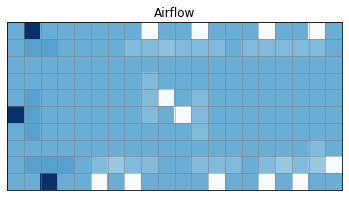

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 432 x 288
DEBUG:matplotlib.animation:MovieWriter: clearing temporary path=<TemporaryDirectory 'C:\\Users\\zacha\\AppData\\Local\\Temp\\tmpbz8ma7ah'>


Number of timesteps to reach fixed point: 41


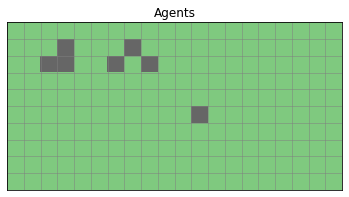

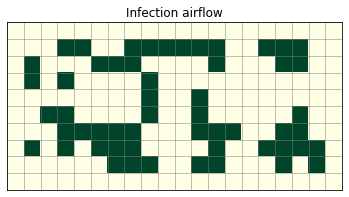

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 432 x 288
DEBUG:matplotlib.animation:MovieWriter: clearing temporary path=<TemporaryDirectory 'C:\\Users\\zacha\\AppData\\Local\\Temp\\tmpggy2th4p'>


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 432 x 288
DEBUG:matplotlib.animation:MovieWriter: clearing temporary path=<TemporaryDirectory 'C:\\Users\\zacha\\AppData\\Local\\Temp\\tmpjoo_diwx'>


infection_count, inverse_social_distance, inverse_tempurature: [7, 1, 36]


In [70]:
class TestSolution:
    def __init__(self, variables, n_objectives):
        self.variables = variables
        self.objectives = [
            0,
        ] * n_objectives

#environment = np.array(
#    [
#        [1, 2, 1, 1, 1, 2, 1, 1, 2, 1],
#        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
#        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
#        [1, 0, 1, 1, 1, 1, 1, 1, 0, 2],
#        [2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
#        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
#        [2, 0, 0, 0, 1, 0, 0, 0, 0, 2],
#        [1, 1, 2, 1, 1, 2, 1, 2, 1, 1],
#    ]
#)  # encoded environment map (walls and windows) (air=0, walls=1, windows=2)

environment = np.array(
    [
        [1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2],
        [1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1],
    ]
)  # encoded environment map (walls and windows) (air=0, walls=1, windows=2)

pathogen_info = PathogenInfo(
    infection_from_contact=0.8,
    infection_from_max_pollutants=0.4,
    max_pollutants=50,
    airborne_decay=-2,
    pathogen_release_payload=10,
)

problem = AutomataOptimisation(environment, pathogen_info, n_objectives=3, verbose=1)
solution = TestSolution(variables=[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1], n_objectives=3)
problem.evaluate(solution)
print(f"infection_count, inverse_social_distance, inverse_tempurature: {solution.objectives}")


In [71]:
# algorithm = NSGAII(AutomataOptimisation())
# algorithm.run(1000)
